In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging 
import optuna
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoLSTM
from neuralforecast.losses.pytorch import HuberLoss
from torch.optim import Adam, RMSprop
import warnings
warnings.filterwarnings("ignore")

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [2]:
root = Path().resolve().parent

In [3]:
general_data= pd.read_csv(f"{root}/data/clean_data/general_data_with_new_features.csv")
general_data

,Unnamed: 0,Date,Adj Close_AAPL,Adj Close_AMZN,Adj Close_CVX,Adj Close_GOOGL,Adj Close_GS,Adj Close_JNJ,Adj Close_JPM,Adj Close_MSFT,...,vol_unemp_risk_XLK,infl_adj_return_XLV,bullish_momentum_XLV,vol_unemp_risk_XLV,infl_adj_return_XLF,bullish_momentum_XLF,vol_unemp_risk_XLF,infl_adj_return_XLE,bullish_momentum_XLE,vol_unemp_risk_XLE
0,0,2022-07-06,140.663284,114.330002,124.785049,113.888962,271.415039,162.839661,103.496696,259.624359,...,0.046391,1.983535,24.302824,0.034714,-0.743631,-157.044481,0.013071,-5.079048,-1516.142213,0.139442
1,1,2022-07-07,144.039139,116.330002,127.213737,118.074867,275.886932,163.022324,106.114395,261.760132,...,0.068143,1.247100,135.389210,0.037418,4.250478,221.570192,0.056944,10.446330,-585.627207,0.217556
2,2,2022-07-08,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,...,0.067313,0.881159,213.879124,0.037619,-0.642849,164.307941,0.058425,-0.124687,-596.733793,0.217429
3,3,2022-07-09,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,...,0.067313,0.000000,213.879124,0.037619,0.000000,164.307941,0.058425,0.000000,-596.733793,0.217429
4,4,2022-07-10,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,...,0.069834,0.000000,366.261201,0.022534,0.000000,255.112925,0.055331,0.000000,466.988223,0.150947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,1055,2025-05-26,195.270004,200.990005,136.539993,168.266296,595.571350,151.639999,259.460022,450.179993,...,0.046877,0.000000,-283.700571,0.031993,0.000000,-143.331502,0.014652,0.000000,-21.921304,0.023596
1056,1056,2025-05-27,200.210007,206.020004,137.830002,172.690933,612.676086,153.250000,264.018066,460.690002,...,0.119160,4.445454,367.242950,0.060288,5.587597,414.665072,0.078346,2.764136,353.503760,0.035325
1057,1057,2025-05-28,200.419998,204.720001,136.020004,172.151596,605.422241,152.429993,262.226685,457.359985,...,0.104362,-1.653741,260.919065,0.067025,-2.147324,321.534746,0.084735,-4.096270,-124.503889,0.071856
1058,1058,2025-05-29,199.949997,205.699997,137.910004,171.652191,601.859985,153.580002,263.102478,458.679993,...,0.103218,2.138516,460.789056,0.069029,1.643364,475.126800,0.084607,2.386130,98.508607,0.080083


In [3]:
general_data= pd.read_csv(f"{root}/data/clean_data/general_data_with_new_features.csv")


def melt_df(df):
    target_cols = [col for col in df.columns if col.startswith('Adj Close_')]
    df_targets = df.melt(
    id_vars='Date',
    value_vars=target_cols,
    var_name='column',
    value_name='y'
   )
    df_targets['unique_id'] = df_targets['column'].str.extract(r'Adj Close_([A-Z]+)')
    df_targets = df_targets.rename(columns={'Date': 'ds'}).drop(columns='column')
    
    non_feature_cols = target_cols + ['Date']
    feature_cols = [col for col in df.columns if col not in non_feature_cols]

    df_feats = df.melt(
        id_vars='Date',
        value_vars=feature_cols,
        var_name='column',
        value_name='value'
    )

    # Extract feature name and ticker from column names like 'momentum_XLE'
    df_feats[['feature', 'unique_id']] = df_feats['column'].str.extract(r'(.+?)_([A-Z]+)$')
    df_feats = df_feats.dropna(subset=['feature', 'unique_id'])  # keep only columns with both parts
    df_feats = df_feats.rename(columns={'Date': 'ds'}).drop(columns='column')

    # Pivot to wide format:- one row per (ds, unique_id) with all features
    df_feats = df_feats.pivot(index=['ds', 'unique_id'], columns='feature', values='value').reset_index()

    # Merge targets with features
    df_ml = pd.merge(df_targets, df_feats, on=['ds', 'unique_id'], how='left')

    # Add macroeconomic variables (gdp, unemployment, inflation)
    macro_cols = ['gdp', 'unemployment', 'inflation']
    df_macro = df[['Date'] + macro_cols].rename(columns={'Date': 'ds'}).drop_duplicates()
    df_ml = pd.merge(df_ml, df_macro, on='ds', how='left')
    df_ml["ds"] = pd.to_datetime(df_ml["ds"])
    return df_ml


df = melt_df(general_data)
df

,ds,y,unique_id,Close,High,Low,Open,Volume,bullish_momentum,infl_adj_return,momentum,returns,vol_unemp_risk,volatility,gdp,unemployment,inflation
0,2022-07-06,140.663284,AAPL,142.919998,144.119995,141.080002,141.350006,74064300.0,743.885262,2.820013,0.028315,0.009561,0.065802,0.018800,26272.011,3.5,294.94
1,2022-07-07,144.039139,AAPL,146.350006,146.550003,143.279999,143.289993,66253700.0,1366.954377,6.994821,0.052031,0.023716,0.084302,0.024086,26272.011,3.5,294.94
2,2022-07-08,144.718216,AAPL,147.039993,147.550003,145.000000,145.259995,64547800.0,1490.523560,1.387237,0.056734,0.004703,0.076674,0.021907,26272.011,3.5,294.94
3,2022-07-09,144.718216,AAPL,147.039993,147.550003,145.000000,145.259995,64547800.0,1490.523560,0.000000,0.056734,0.000000,0.076674,0.021907,26272.011,3.5,294.94
4,2022-07-10,144.718216,AAPL,147.039993,147.550003,145.000000,145.259995,64547800.0,997.833167,0.000000,0.037981,0.000000,0.077028,0.022008,26272.011,3.5,294.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14835,2025-05-26,129.720734,XLV,130.339996,130.600006,129.550003,129.929993,9127100.0,-283.700571,0.000000,-0.009469,0.000000,0.031993,0.007617,29962.047,4.2,320.58
14836,2025-05-27,131.532089,XLV,132.160004,132.389999,131.160004,131.429993,12304000.0,367.242950,4.445454,0.012257,0.013867,0.060288,0.014354,29962.047,4.2,320.58
14837,2025-05-28,130.855316,XLV,131.479996,132.580002,131.130005,132.110001,11087500.0,260.919065,-1.653741,0.008708,-0.005159,0.067025,0.015958,29962.047,4.2,320.58
14838,2025-05-29,131.731140,XLV,132.360001,132.759995,131.289993,131.679993,10670300.0,460.789056,2.138516,0.015379,0.006671,0.069029,0.016435,29962.047,4.2,320.58


In [4]:
def my_lstm_config(trial: optuna.Trial):
    """Hyperparameter configuration for LSTM"""
    config = {
        'input_size': trial.suggest_int('input_size', 7, 21),
        'encoder_n_layers': trial.suggest_int('encoder_n_layers', 2, 3),
        'encoder_bias': trial.suggest_categorical('encoder_bias', [True, False]),
        'encoder_dropout': trial.suggest_float('encoder_dropout', 0.0, 1.0),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-7, 1e-3),
        "encoder_hidden_size": trial.suggest_int("encoder_hidden_size", 32, 256),
        "decoder_hidden_size": trial.suggest_int("decoder_hidden_size", 32, 256),
        'decoder_layers': trial.suggest_int('decoder_layers', 2, 3),
        "batch_size": trial.suggest_int("batch_size", 32, 128),
        "random_seed": trial.suggest_int("random_seed", 1, 10), 
        'early_stop_patience_steps': trial.suggest_int('early_stop_patience_steps', 3, 10),
        "recurrent": trial.suggest_categorical('recurrent', [True, False]),
        'scaler_type': 'robust', 
        "exclude_insample_y": True,
        "optimizer" : trial.suggest_categorical("optimizer", [Adam, RMSprop]),
        "hist_exog_list": ["Close", "High", "Low", "Open", "Volume", "bullish_momentum", "infl_adj_return", "momentum", "returns", "vol_unemp_risk", "volatility", "gdp", "unemployment",	"inflation"],
    }
    trainer_kwargs = {
        'max_steps': trial.suggest_int('max_steps', 100, 300),
        "enable_checkpointing": True,
        'gradient_clip_val': trial.suggest_float('gradient_clip_val', 1.0, 5.0)
    }
    config.update(**trainer_kwargs)
    return config




models = [

    AutoLSTM(
    h=7,  
    loss=HuberLoss(delta=1.35),  
    config=my_lstm_config,
    search_alg=optuna.samplers.TPESampler(),
    backend="optuna",
    num_samples=10,
    ),


    
]

nf = NeuralForecast(models=models, freq='D')

In [5]:
nf.fit(df=df, val_size=14)

[I 2025-07-13 12:52:55,211] A new study created in memory with name: no-name-6c5f3bc8-fc03-4e16-b2ba-67286798f315
Seed set to 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:53:38,914] Trial 0 finished with value: 4.1775312423706055 and parameters: {'input_size': 13, 'encoder_n_layers': 2, 'encoder_bias': False, 'encoder_dropout': 0.7465244358240549, 'learning_rate': 0.0008281318632466645, 'encoder_hidden_size': 176, 'decoder_hidden_size': 80, 'decoder_layers': 2, 'batch_size': 109, 'random_seed': 4, 'early_stop_patience_steps': 10, 'recurrent': True, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 207, 'gradient_clip_val': 3.30346359561353}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:53:56,443] Trial 1 finished with value: 7.024617671966553 and parameters: {'input_size': 19, 'encoder_n_layers': 3, 'encoder_bias': False, 'encoder_dropout': 0.38428415685136463, 'learning_rate': 2.896565549111241e-06, 'encoder_hidden_size': 61, 'decoder_hidden_size': 230, 'decoder_layers': 3, 'batch_size': 89, 'random_seed': 6, 'early_stop_patience_steps': 3, 'recurrent': False, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 118, 'gradient_clip_val': 1.8313181167940495}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:54:03,378] Trial 2 finished with value: 5.886974811553955 and parameters: {'input_size': 12, 'encoder_n_layers': 3, 'encoder_bias': False, 'encoder_dropout': 0.681546602512965, 'learning_rate': 3.4251043008880287e-07, 'encoder_hidden_size': 75, 'decoder_hidden_size': 144, 'decoder_layers': 2, 'batch_size': 65, 'random_seed': 2, 'early_stop_patience_steps': 8, 'recurrent': False, 'optimizer': <class 'torch.optim.adam.Adam'>, 'max_steps': 105, 'gradient_clip_val': 2.0728682577318622}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:55:14,276] Trial 3 finished with value: 10.407094955444336 and parameters: {'input_size': 17, 'encoder_n_layers': 2, 'encoder_bias': True, 'encoder_dropout': 0.9790210770526281, 'learning_rate': 5.6669493851305894e-05, 'encoder_hidden_size': 238, 'decoder_hidden_size': 207, 'decoder_layers': 3, 'batch_size': 44, 'random_seed': 10, 'early_stop_patience_steps': 3, 'recurrent': False, 'optimizer': <class 'torch.optim.adam.Adam'>, 'max_steps': 230, 'gradient_clip_val': 3.298893025615427}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:55:33,924] Trial 4 finished with value: 8.00810432434082 and parameters: {'input_size': 20, 'encoder_n_layers': 3, 'encoder_bias': False, 'encoder_dropout': 0.3487919851274458, 'learning_rate': 2.093996776470226e-06, 'encoder_hidden_size': 51, 'decoder_hidden_size': 244, 'decoder_layers': 2, 'batch_size': 97, 'random_seed': 1, 'early_stop_patience_steps': 9, 'recurrent': False, 'optimizer': <class 'torch.optim.adam.Adam'>, 'max_steps': 124, 'gradient_clip_val': 1.0239077659702636}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:55:56,833] Trial 5 finished with value: 5.546346187591553 and parameters: {'input_size': 10, 'encoder_n_layers': 3, 'encoder_bias': False, 'encoder_dropout': 0.916167378585228, 'learning_rate': 4.721842018813088e-05, 'encoder_hidden_size': 94, 'decoder_hidden_size': 193, 'decoder_layers': 3, 'batch_size': 100, 'random_seed': 1, 'early_stop_patience_steps': 9, 'recurrent': False, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 163, 'gradient_clip_val': 4.144341757774718}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:56:21,157] Trial 6 finished with value: 7.517306804656982 and parameters: {'input_size': 21, 'encoder_n_layers': 2, 'encoder_bias': True, 'encoder_dropout': 0.8703095079222551, 'learning_rate': 0.00020785138255884834, 'encoder_hidden_size': 36, 'decoder_hidden_size': 91, 'decoder_layers': 2, 'batch_size': 101, 'random_seed': 8, 'early_stop_patience_steps': 10, 'recurrent': True, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 174, 'gradient_clip_val': 3.4345571954028173}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:57:06,300] Trial 7 finished with value: 7.921716213226318 and parameters: {'input_size': 19, 'encoder_n_layers': 2, 'encoder_bias': True, 'encoder_dropout': 0.12592308072247094, 'learning_rate': 1.096970406766396e-05, 'encoder_hidden_size': 253, 'decoder_hidden_size': 117, 'decoder_layers': 3, 'batch_size': 82, 'random_seed': 7, 'early_stop_patience_steps': 3, 'recurrent': True, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 194, 'gradient_clip_val': 1.0731867322942503}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:57:43,712] Trial 8 finished with value: 7.182430744171143 and parameters: {'input_size': 17, 'encoder_n_layers': 3, 'encoder_bias': True, 'encoder_dropout': 0.3632566176917832, 'learning_rate': 8.567393161999958e-07, 'encoder_hidden_size': 40, 'decoder_hidden_size': 80, 'decoder_layers': 3, 'batch_size': 57, 'random_seed': 10, 'early_stop_patience_steps': 8, 'recurrent': True, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'max_steps': 248, 'gradient_clip_val': 1.4866107864523754}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-13 12:58:10,414] Trial 9 finished with value: 4.4880242347717285 and parameters: {'input_size': 10, 'encoder_n_layers': 2, 'encoder_bias': True, 'encoder_dropout': 0.6984934273386, 'learning_rate': 0.0004118070600555033, 'encoder_hidden_size': 111, 'decoder_hidden_size': 203, 'decoder_layers': 3, 'batch_size': 127, 'random_seed': 9, 'early_stop_patience_steps': 5, 'recurrent': True, 'optimizer': <class 'torch.optim.adam.Adam'>, 'max_steps': 211, 'gradient_clip_val': 4.281338493987537}. Best is trial 0 with value: 4.1775312423706055.
Seed set to 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
results = nf.models[0].results.trials_dataframe()

In [7]:
BEST_PARAM = results[results['value'] == min(results['value'])]['user_attrs_ALL_PARAMS']


In [8]:
for each in BEST_PARAM:
    print(each)

{'input_size': 13, 'encoder_n_layers': 2, 'encoder_bias': False, 'encoder_dropout': 0.7465244358240549, 'learning_rate': 0.0008281318632466645, 'encoder_hidden_size': 176, 'decoder_hidden_size': 80, 'decoder_layers': 2, 'batch_size': 109, 'random_seed': 4, 'early_stop_patience_steps': 10, 'recurrent': True, 'scaler_type': 'robust', 'exclude_insample_y': True, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'hist_exog_list': ['Close', 'High', 'Low', 'Open', 'Volume', 'bullish_momentum', 'infl_adj_return', 'momentum', 'returns', 'vol_unemp_risk', 'volatility', 'gdp', 'unemployment', 'inflation'], 'max_steps': 207, 'enable_checkpointing': True, 'gradient_clip_val': 3.30346359561353, 'h': 7, 'loss': HuberLoss(), 'valid_loss': HuberLoss()}


In [9]:
pred = nf.predict()
pred 

Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoLSTM
0,AAPL,2025-05-31,201.413635
1,AAPL,2025-06-01,201.240189
2,AAPL,2025-06-02,201.011932
3,AAPL,2025-06-03,200.821426
4,AAPL,2025-06-04,200.683304
...,...,...,...
93,XOM,2025-06-02,102.798012
94,XOM,2025-06-03,102.877495
95,XOM,2025-06-04,102.931770
96,XOM,2025-06-05,102.967476


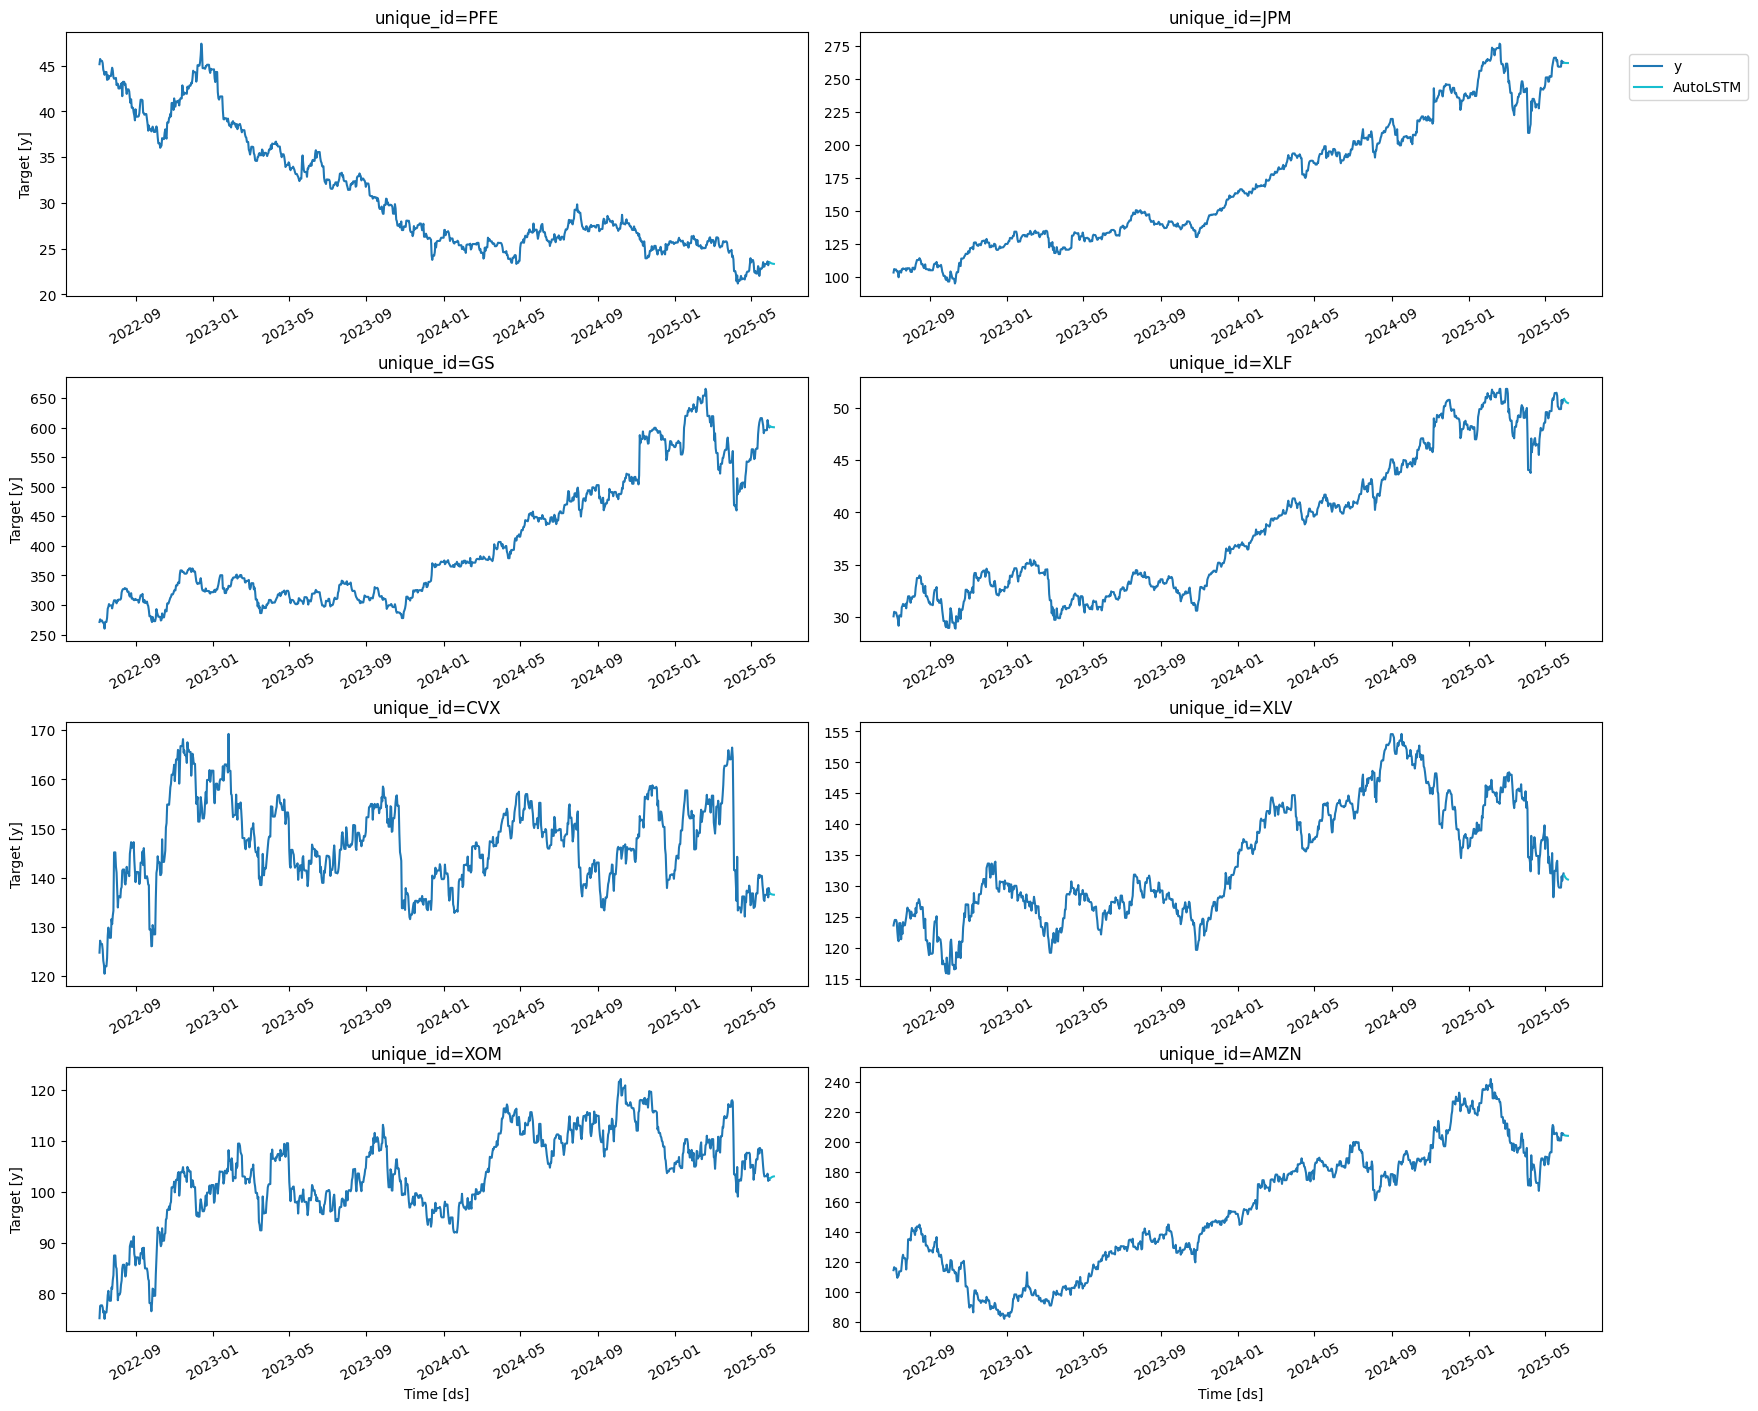

In [10]:
from utilsforecast.plotting import plot_series
plot_series(df, pred)


In [11]:
nf.save(path=f'{root}/models/LSTM',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [12]:
nf2 = NeuralForecast.load(path=f'{root}/models/LSTM')

Seed set to 4


In [13]:
cv_df = nf2.cross_validation(df, n_windows=2, val_size= 14, step_size= 14)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

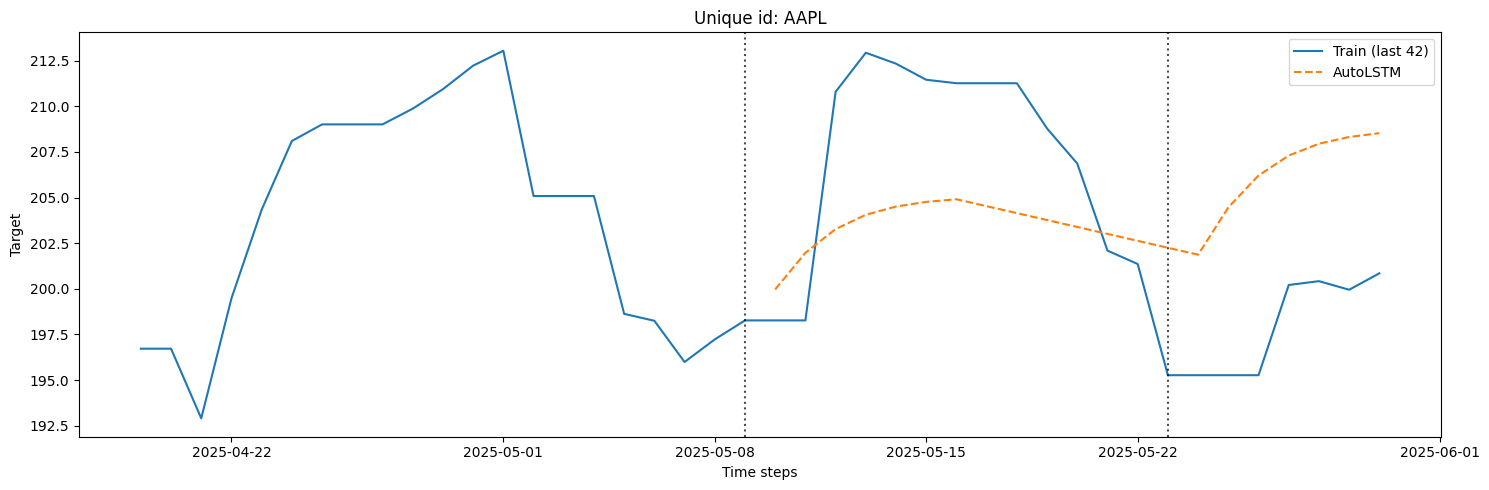

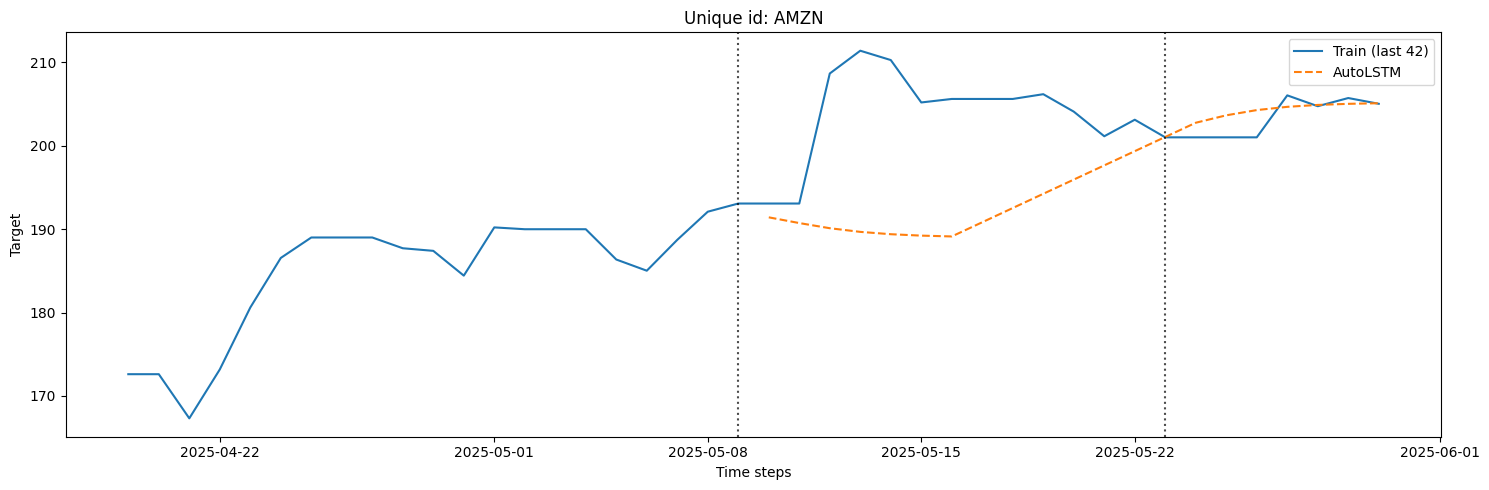

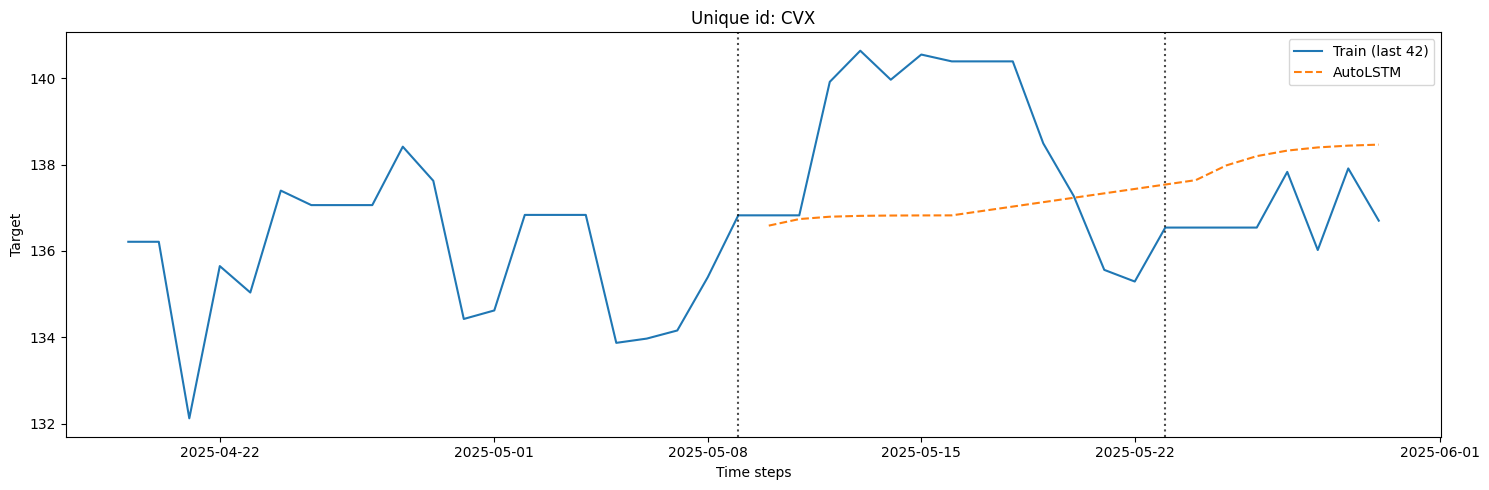

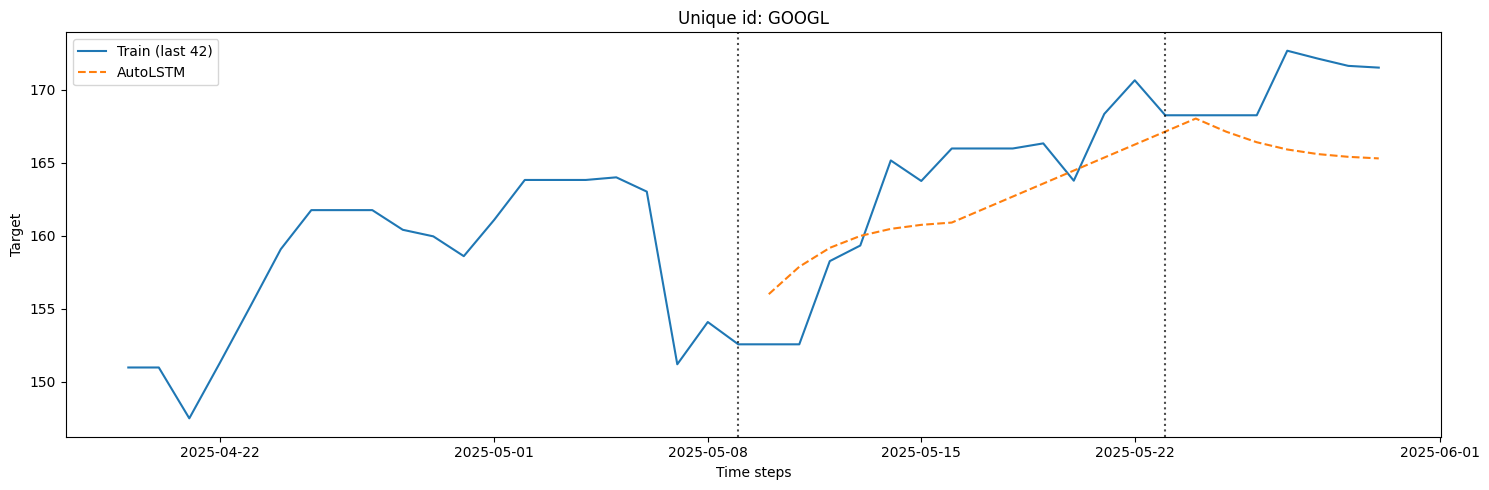

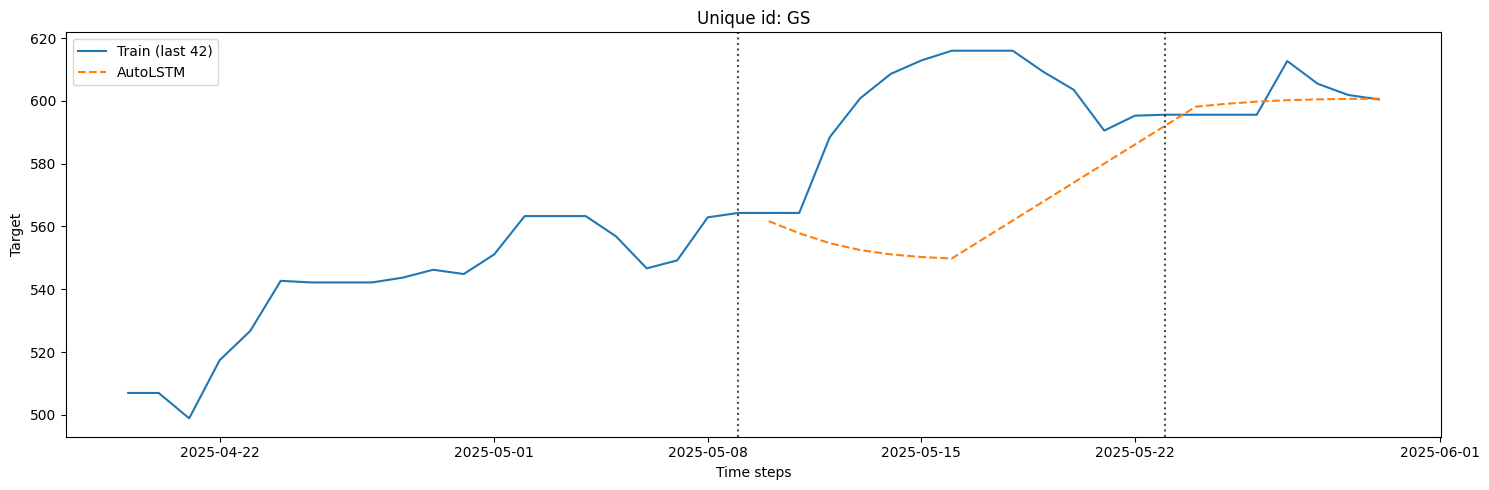

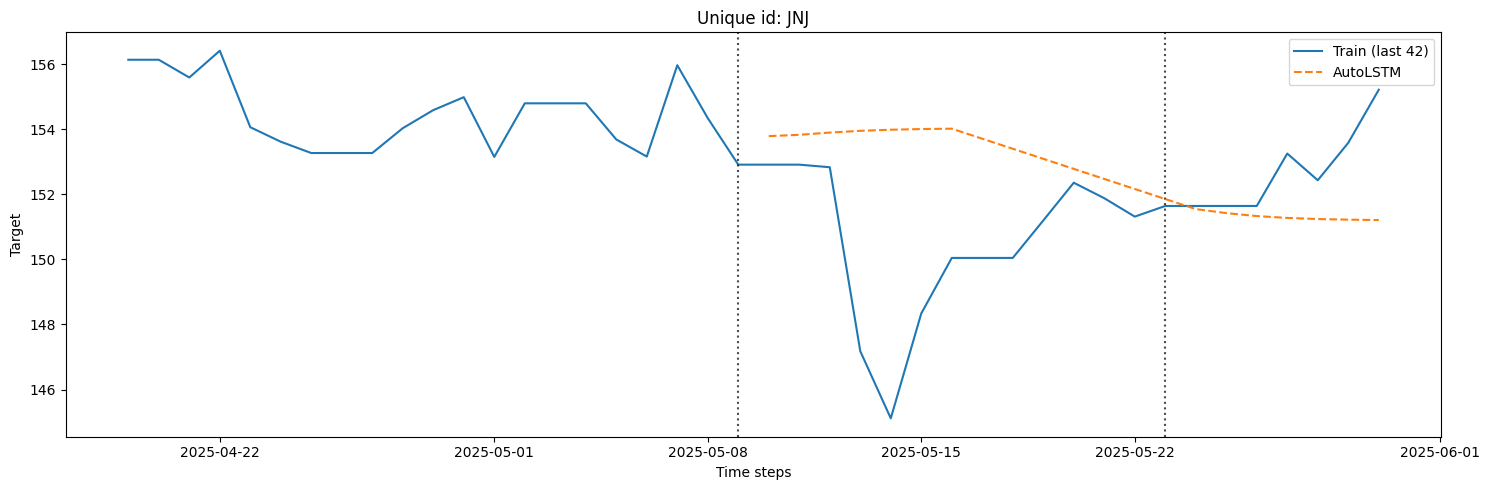

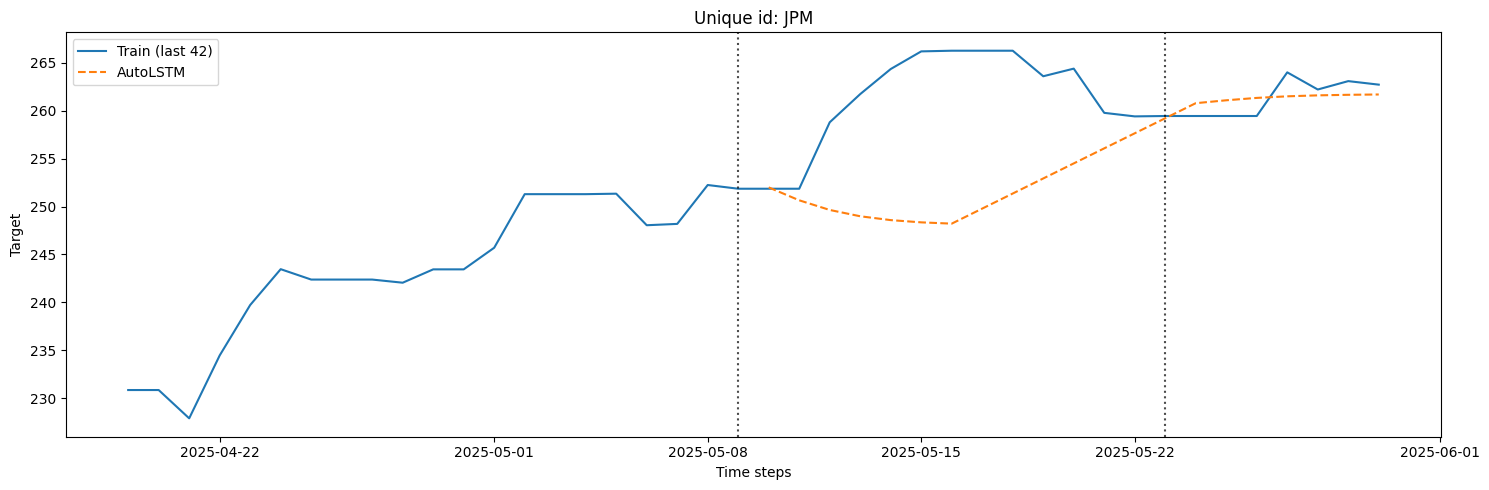

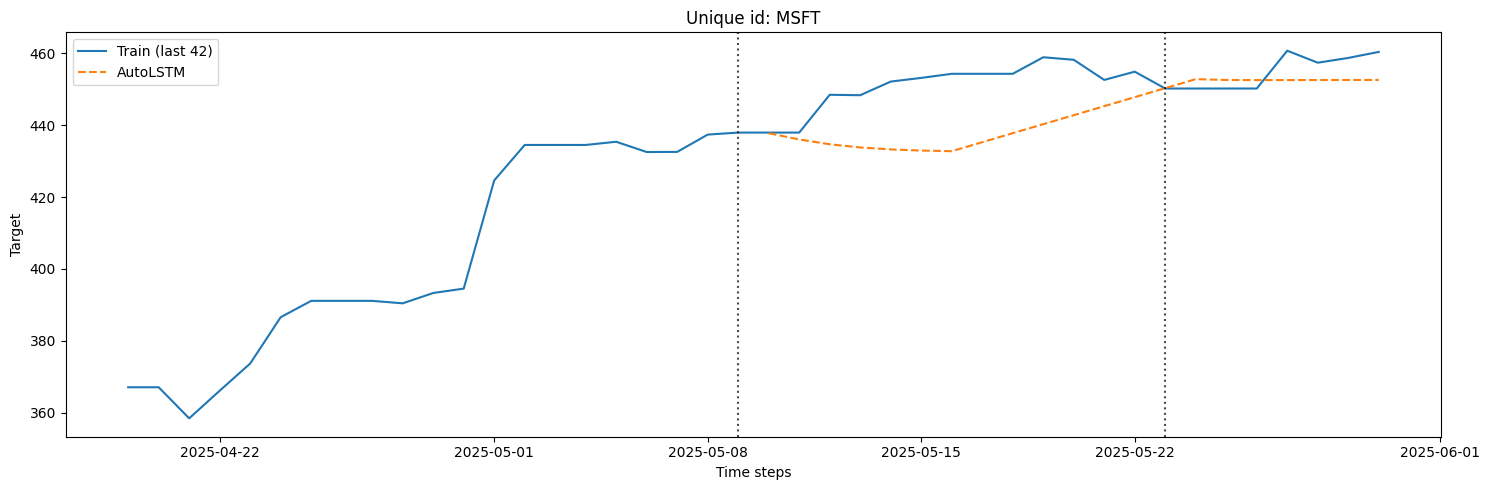

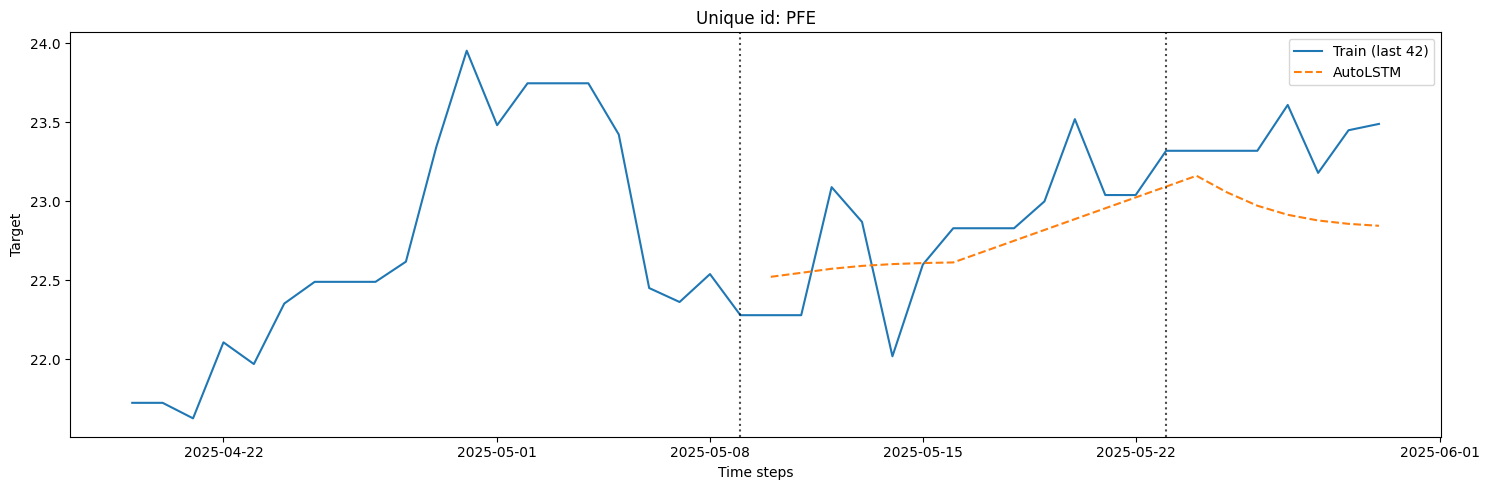

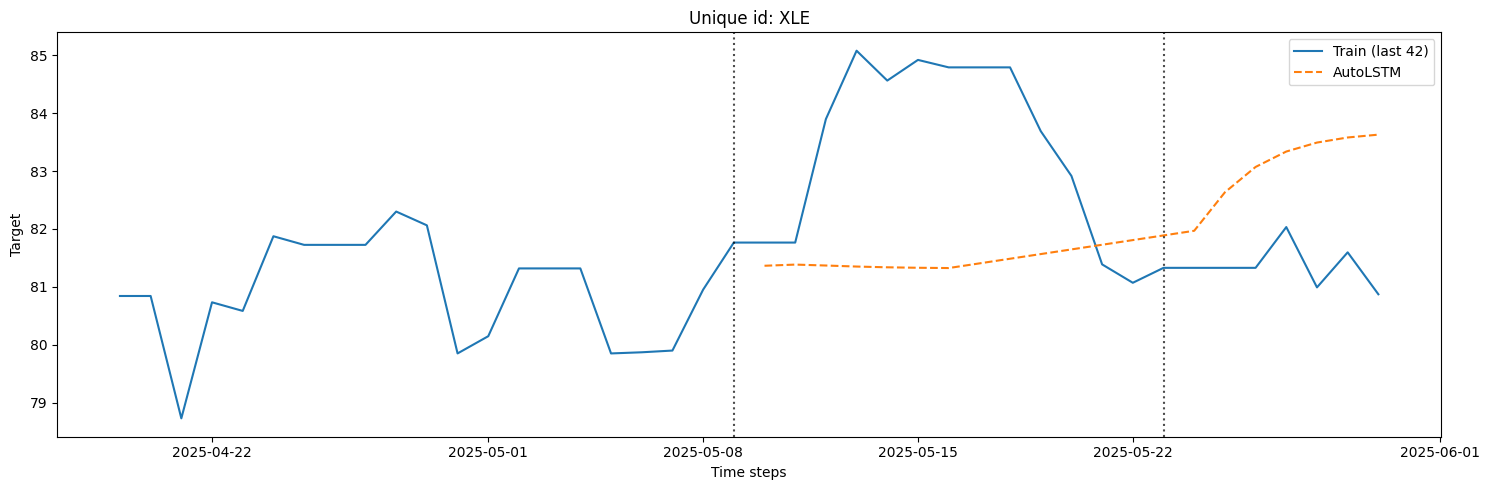

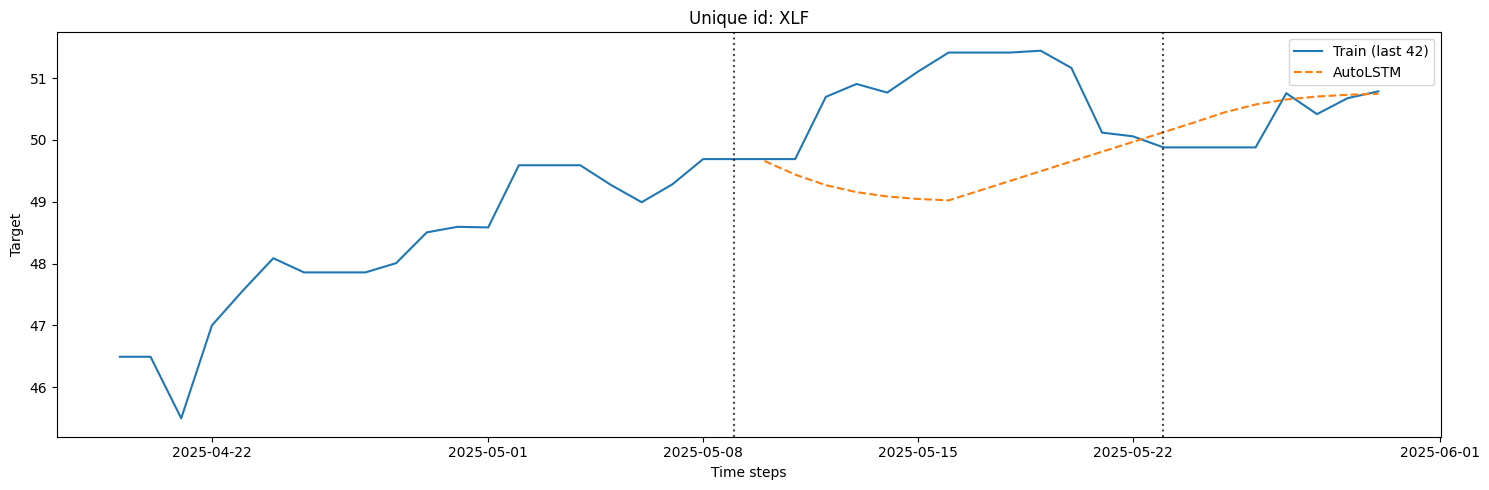

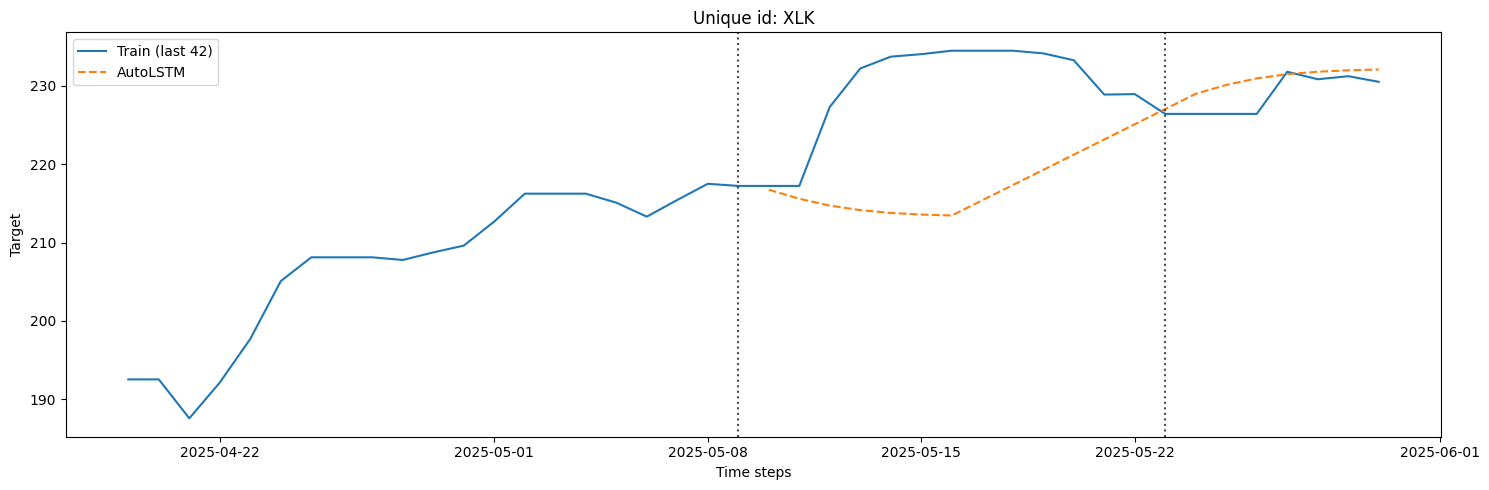

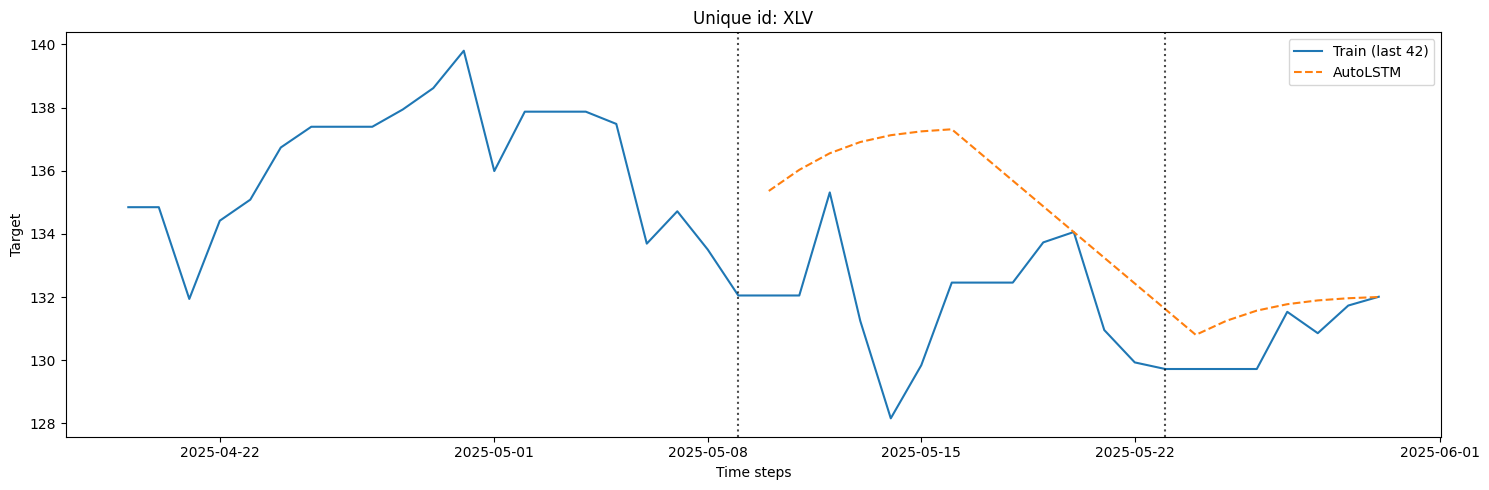

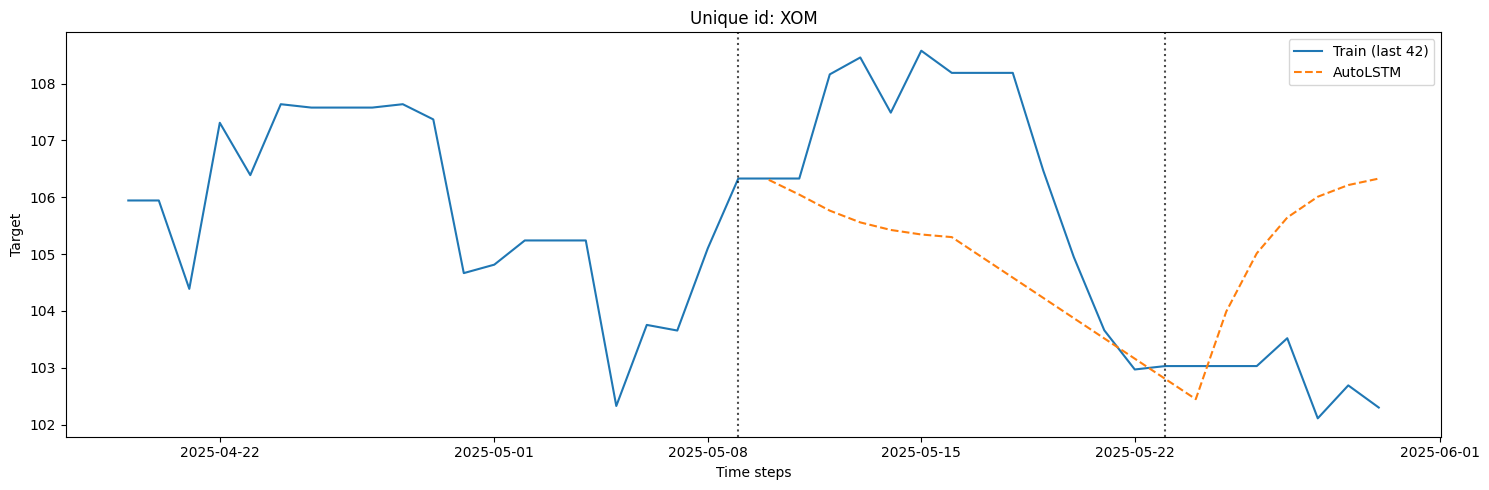

In [14]:
k = 3 
cutoffs = cv_df['cutoff'].unique()

for uid, df_slice in df.groupby('unique_id'):
    cv_slice = cv_df[cv_df['unique_id'] == uid]

    forecast_len = len(cv_slice)
    keep_len      = k * forecast_len 
    train_zoomed  = df_slice.tail(keep_len)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(train_zoomed['ds'],
            train_zoomed['y'],
            label=f'Train (last {keep_len})')

    ax.plot(cv_slice['ds'],
            cv_slice['AutoLSTM'],
            ls='--',
            label='AutoLSTM')

    for c in cutoffs:
        ax.axvline(c, color='black', ls=':', alpha=0.7)

    ax.set_title(f'Unique id: {uid}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Target')
    ax.legend()
    fig.tight_layout()
    plt.show()
